## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Camera calibration

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
gray = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calibrate the camera

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (gray.shape[::-1]), None, None)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def undistort(img):    
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Check calibration result

In [ ]:
undist = []
plt.figure(1, figsize=(50,50))
i = 0

for fname in images:
    img = cv2.imread(fname)
    undist = undistort(img)
    #plt.subplot(len(images), 1 , i+1)
    #plt.imshow(undist)
    i = i +1 
    undist_file_name = "camera_cal/"+"undistort"+str(i)+".jpg"
    origin_file_name = "camera_cal/"+"origin"+str(i)+".jpg"

    cv2.imwrite(undist_file_name,undist)
    cv2.imwrite(origin_file_name,img)

In [ ]:
##### Before calibration
import pickle
pickle.dump( (ret, mtx, dist, rvecs, tvecs), open( "calib.p", "wb" ) )


 ### Load calibration result for further processing

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
(ret, mtx, dist, rvecs, tvecs) = pickle.load( open( "calib.p", "rb" ))

In [3]:
def undistort_img(img, mtx, dist):    
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

In [4]:
##### Before calibration
# parameters
s_thresh=(170, 255)
sx_thresh=(20, 100)

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

def binarize_img(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 100))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(100, 200))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_channel = hls_select(img, thresh=(150, 255))
     # Stack each channel
      
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_channel == 1) | (combined == 1)] = 1
    
    return combined_binary
        

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)): 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
     # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

### Perspective Transformation 

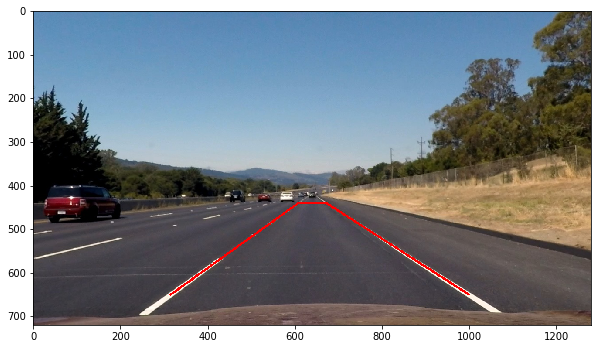

In [6]:
plt.figure(1, figsize=(10,10))

straight_line = cv2.imread('test_images/straight_lines2.jpg')
straight_line_rgb = cv2.cvtColor(straight_line, cv2.COLOR_BGR2RGB)

# undistort 
straight_line_rgb_undistort = undistort_img(straight_line_rgb, mtx, dist)    
# 
pt1 = (315 , 650  )
pt2 = (608 , 440  )
pt3 = (673,  440)
pt4 = (1000, 650)
cv2.line(straight_line_rgb_undistort, pt1, pt2, (255,0,0), thickness=3 ) 
cv2.line(straight_line_rgb_undistort, pt2, pt3, (255,0,0), thickness=3 ) 
cv2.line(straight_line_rgb_undistort, pt3, pt4, (255,0,0), thickness=3 ) 

plt.imshow(straight_line_rgb_undistort )


In [7]:
image_shape = straight_line_rgb.shape
image_shape[0:2]

(720, 1280)

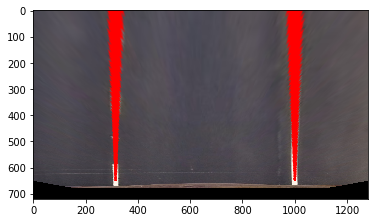

In [8]:
pt2_dist = (pt1[0] , -440  )
pt3_dist = (pt4[0] , -440  )
src = np.float32([pt1,pt2,pt3,pt4]) 
dst = np.float32([pt1,pt2_dist,pt3_dist,pt4])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(straight_line_rgb_undistort, M , (1280,720))
plt.imshow(warped )
#pickle.dump( M, open( "warp_perspective.p", "wb" ) )


In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# parameters
image_shape_g =  (1280,720)
M_g = pickle.load( open( "warp_perspective.p", "rb" ))


In [10]:
def perspective_transform(img):
    return cv2.warpPerspective(img, M_g , image_shape_g)


In [11]:
def pipeline(img):
    # undistort
    undistort = undistort_img(img, mtx, dist)
    # binarize
    (combined_binary) = binarize_img(undistort)
    # perspective transform
    img_perspective = perspective_transform(combined_binary)
    
    return (img_perspective, undistort , combined_binary)

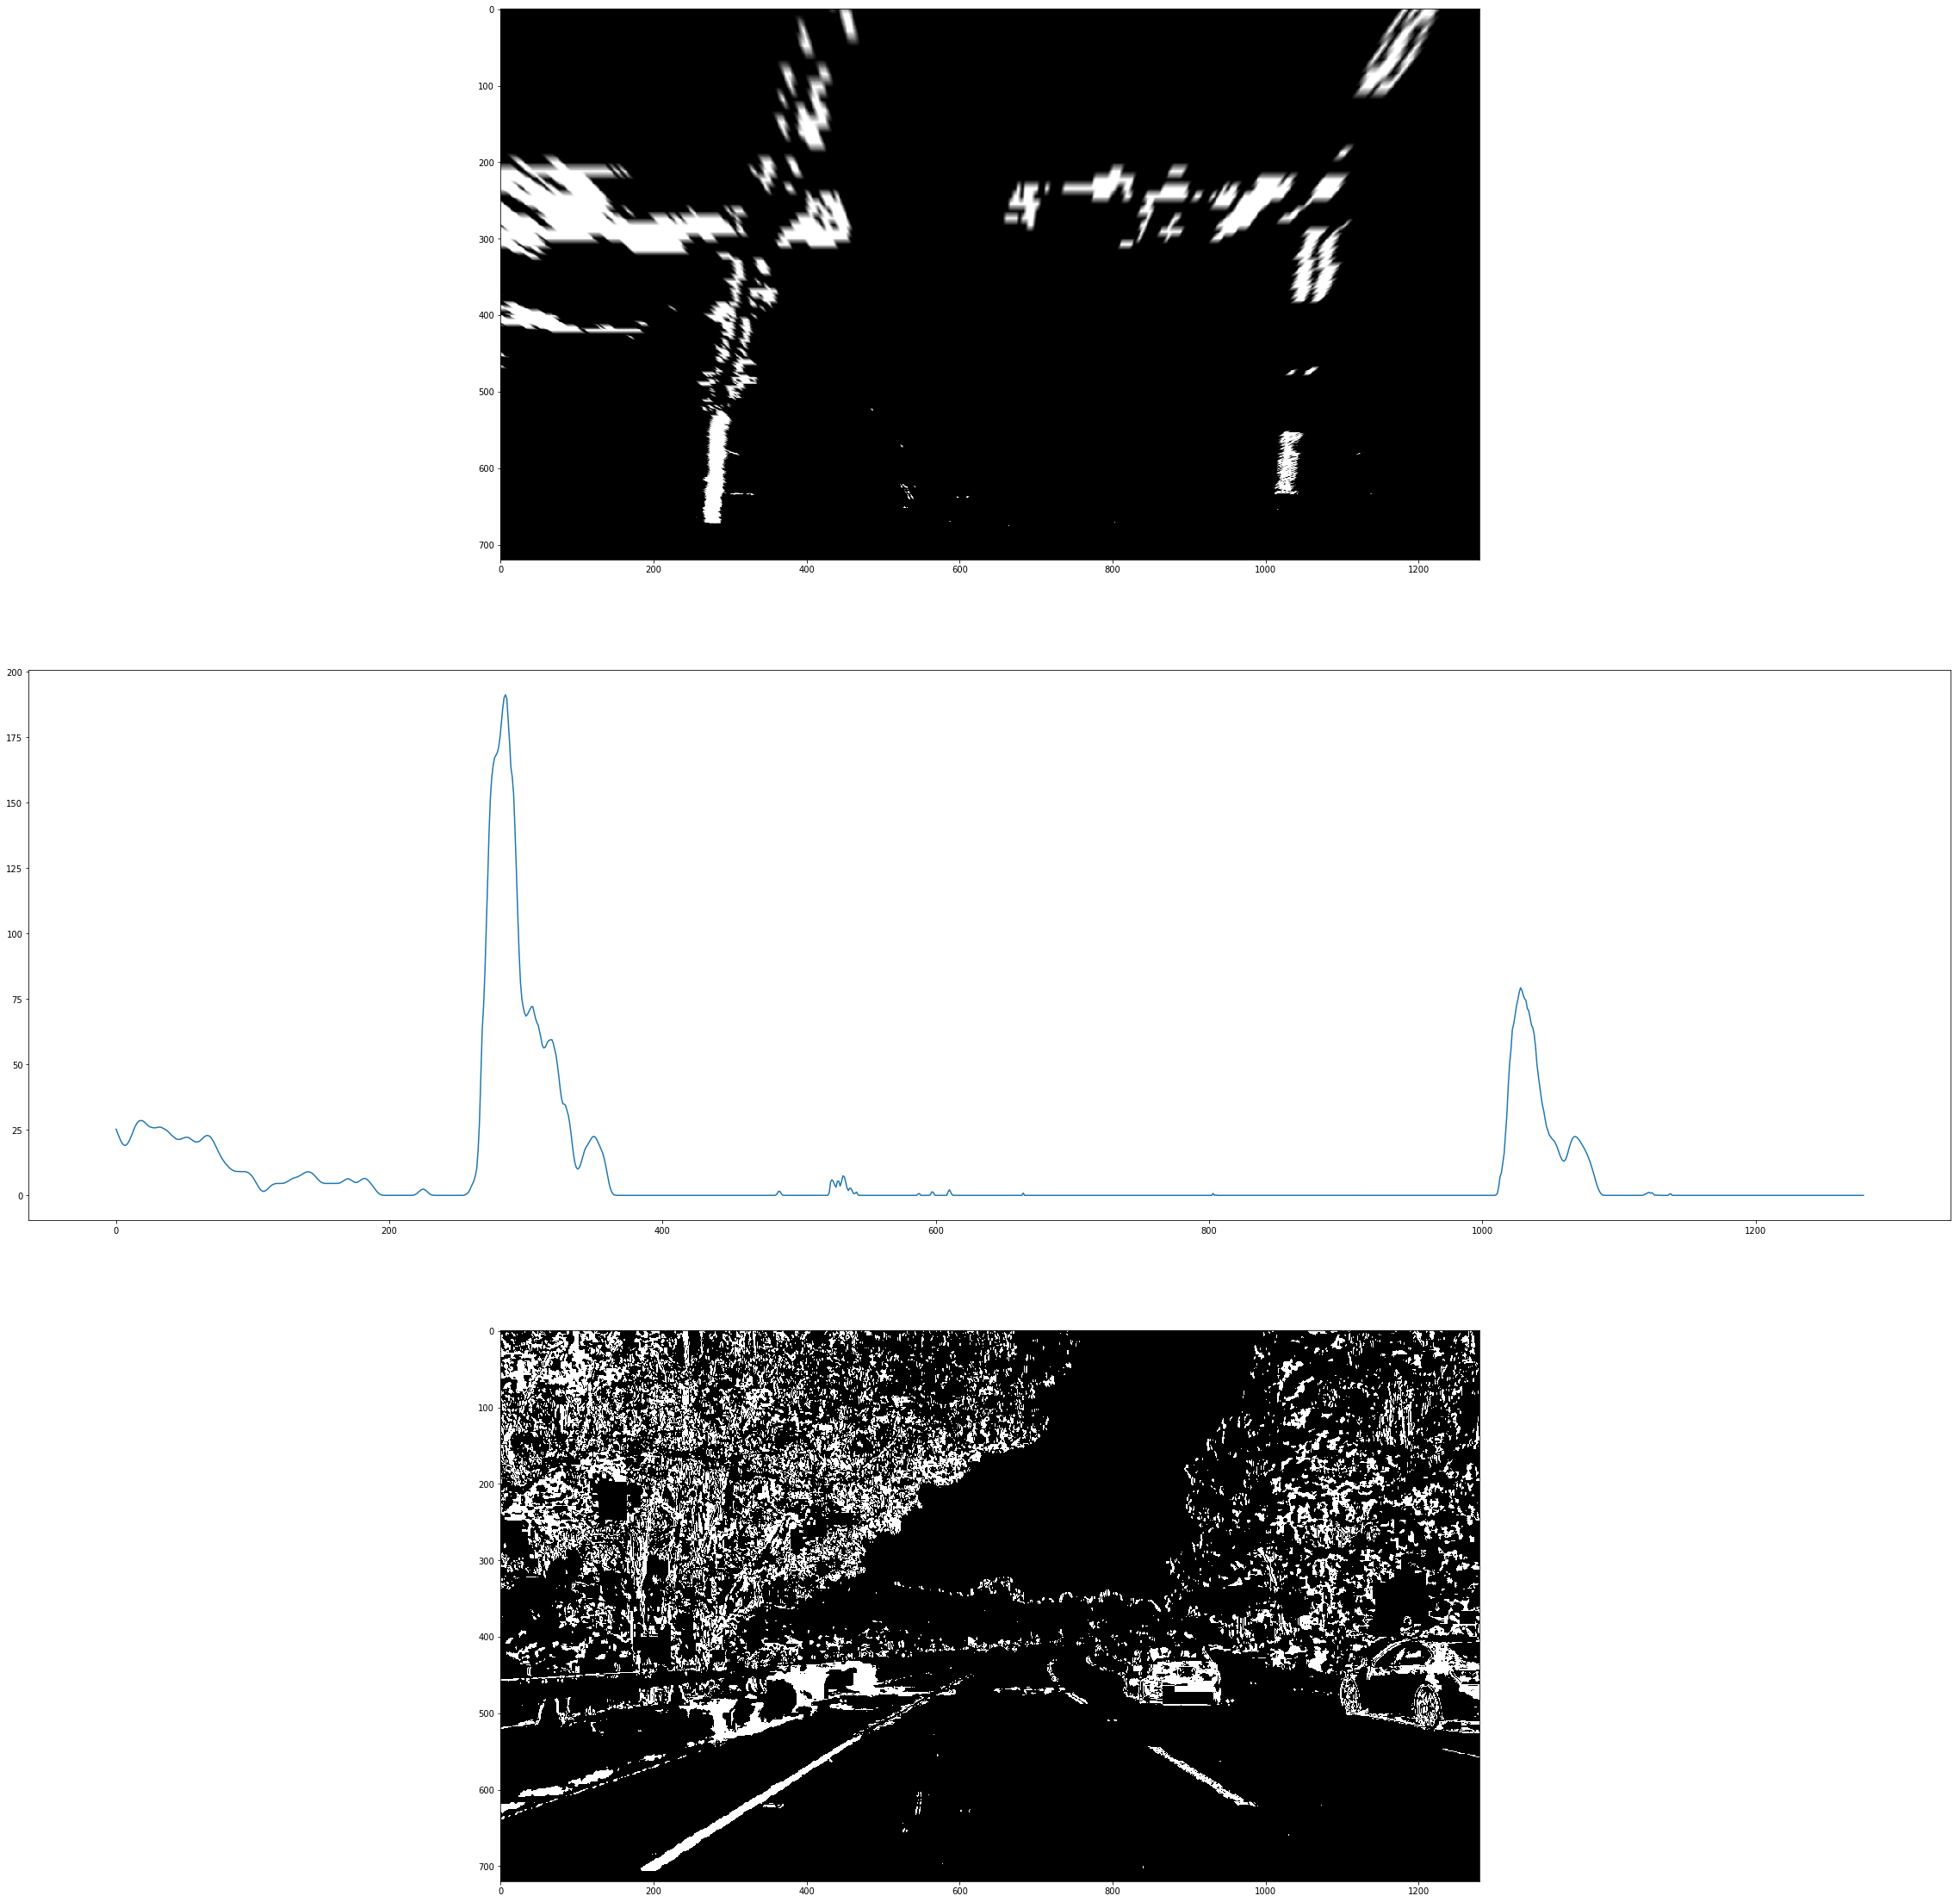

In [12]:
import numpy as np

plt.figure(1, figsize=(40,40))


img = cv2.imread('test_images/test5.jpg')

(img_perspective, undistort , combined_binary) = pipeline(img)
#histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.subplot(3,1,1)
#plt.plot(histogram)
plt.imshow(img_perspective , cmap='gray')
plt.subplot(3, 1 , 2 )
histogram = np.sum(img_perspective[img_perspective.shape[0]//2:,:], axis=0)
plt.plot(histogram )
plt.subplot(3,1,3)
plt.imshow(combined_binary , cmap='gray')


### Line detection from warped image

In [13]:
import copy
def find_lane( image_warped ):
    binary_warped = copy.copy(image_warped)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img = out_img.astype( np.uint8)
    # Find the peak of the left and right halves of the histogram
    # plt.imshow(binary_warped , cmap='gray')
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print (midpoint, leftx_base, rightx_base)

    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #print ('None zero y ', nonzeroy)
    #print ('None zero x ', nonzerox)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    length_lane_pixel = 750 # this parameter is updated dynamically
    # 
    dynam_mpix = 500
    lane_width_divergence = 38 # parameter to determine if the window should be considered 
    
    # Step through the windows one by one
    window_nr = 0
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image 
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # check std deviation of lane width within one window  
        leftx_window = nonzerox[good_left_inds] 
        rightx_window = nonzerox[good_right_inds] 
        pixel_divergence_left = np.std(leftx_window)
        pixel_divergence_right = np.std(rightx_window)

        # Append these indices to the lists
        if len(good_left_inds) > minpix and pixel_divergence_left < lane_width_divergence:           
            left_lane_inds.append(good_left_inds)
        else:
            if len(good_right_inds) > minpix and window_nr > 5 :
                # append new non zero index 
                rightx_offset = nonzerox[good_right_inds] - length_lane_pixel
                righty_offset = nonzeroy[good_right_inds] 
                left_lane_inds.append(list(range( nonzeroy.shape[0], nonzeroy.shape[0]+ righty_offset.shape[0])) )
                nonzeroy = np.append(nonzeroy , righty_offset)
                nonzerox = np.append(nonzerox , rightx_offset)
                    
            
        if len(good_right_inds) > minpix and pixel_divergence_right < lane_width_divergence:           
            right_lane_inds.append(good_right_inds)
        else:
            if len(good_left_inds) > minpix and window_nr > 5:
                leftx_offset = nonzerox[good_left_inds] +  length_lane_pixel
                lefty_offset = nonzeroy[good_left_inds] 
                right_lane_inds.append(list(range( nonzeroy.shape[0], nonzeroy.shape[0] + lefty_offset.shape[0])))
                nonzeroy = np.append(nonzeroy , lefty_offset)
                nonzerox = np.append(nonzerox , leftx_offset)
                
            
        # If you found > minpix pixels, recenter next window on their mean position
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if  len(good_left_inds) > dynam_mpix and len(good_right_inds) > dynam_mpix:
            length_lane_pixel =  rightx_current - leftx_current
            # print ('dynamic lane pixel', length_lane_pixel)
        
        window_nr = window_nr + 1
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # compute curvature 
    (c_left, c_right, offset,  left_fit_cr ,right_fit_cr ) = compute_curvature (leftx, lefty, rightx, righty)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit, c_left, c_right, offset ,  left_fit_cr ,right_fit_cr )

### Compute curvature

In [14]:
ym_per_pix = 50.0/720.0 # meters per pixel in y dimension 
xm_per_pix = 3.7/685.0 # meters per pixel in x dimension (calculated from calibration step)


def evaluate_x (fit_world, y_pixel):
    '''
    compute the x cooridnate based on polynomial fit
    '''
    y_eval_meter = y_pixel * ym_per_pix
    return fit_world[0] *  y_eval_meter **2  + fit_world[1] * y_eval_meter + fit_world[2]
 

def compute_curvature (leftx, lefty, rightx, righty):
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)   

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature 
    # f(y)=Ay^2 + By + C    
    # A  = left_fit_cr[0]
    # B = left_fit_cr[1]
    # C = left_fit_cr[1]
    left_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculate offset 
    y_eval_meter = y_eval*ym_per_pix
    x_left_bottom =  left_fit_cr[0] *  y_eval_meter * y_eval_meter + left_fit_cr[1] * y_eval_meter + left_fit_cr[2]
    x_right_bottom =  right_fit_cr[0] *  y_eval_meter * y_eval_meter + right_fit_cr[1] * y_eval_meter + right_fit_cr[2]

    offset = (x_left_bottom + x_right_bottom ) * 0.5   
    #print ('x_left_bottom', x_left_bottom)
    #print ('x_right_bottom', x_right_bottom)
    middle_meter = xm_per_pix * 1280 / 2.0
    return (left_rad,  right_rad, offset - middle_meter , left_fit_cr ,right_fit_cr  )


### Tracking lane line

In [15]:
def track_lane_line(image_perpective, left_fit, right_fit ):
    binary_warped = copy.copy(image_perpective)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # compute deviation of position x

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # right 
    leftx_margin = left_fit[0]*(lefty**2) + left_fit[1]*lefty + left_fit[2] - margin    
    div_left  = np.std(leftx - leftx_margin)
    rightx_margin = right_fit[0]*(righty**2) + right_fit[1]*righty + right_fit[2] - margin 
    div_right = np.std(rightx - rightx_margin)
    div_sum =  div_left + div_right
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # compute curvature and determine if tracking is lost 
    (curvature_left, curvature_right, offset_mid ,  left_fit_cr ,right_fit_cr ) = compute_curvature (leftx, lefty, rightx, righty)
    #print ('curvature ',curvature_left , curvature_right)
    #print ('radius difference ', np.fabs(curvature_left - curvature_right))
    return (ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy , curvature_left, curvature_right, offset_mid ,  left_fit_cr ,right_fit_cr , div_sum)

In [16]:
def visualize_tracking(binary_warped, ploty, left_fitx, right_fitx ,left_lane_inds, right_lane_inds, nonzerox,nonzeroy, margin ):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype( np.uint8)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


### Inverse the warped image and draw result

In [17]:
def inverse_warp(undist,   left_fitx , right_fitx, ploty , Minv):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(undist).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros_like(undist).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
# plt.imshow(result)

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # 
        self.left_fit_list  = []
        self.right_fit_list = []
        self.left_fit_average = None
        self.right_fit_average = None
        self.image_height = 720
        self.left_fitx = None
        self.right_fitx = None
        self.left_fit_current = None
        self.right_fit_current = None
        self.left_fit_last = None
        self.right_fit_last = None
        self.left_curvature = None
        self.right_curvature = None
        
    def add_new_curvature(self, c_left, c_right):
        self.left_curvature = c_left
        self.right_curvature = c_right
        
    def add_new_fit(self, left_fit, right_fit, queue_nr):
        # update last fit to current
        self.left_fit_last  = self.left_fit_current
        self.right_fit_last = self.right_fit_current

        # current detection result
        self.left_fit_current = left_fit
        self.right_fit_current = right_fit
        
        if len( self.left_fit_list) > queue_nr:
            self.left_fit_list.pop(0)
            self.right_fit_list.pop(0)           
        self.left_fit_list.append(left_fit)
        self.right_fit_list.append(right_fit)
        # compute average fit 
        sum_left_fit = np.array([0,0,0])
        sum_right_fit = np.array([0,0,0])
        for l_fit in self.left_fit_list:
            sum_left_fit = sum_left_fit + l_fit
        for r_fit in self.right_fit_list:
            sum_right_fit = sum_right_fit + r_fit
        # compute average fit 
        self.left_fit_average  = sum_left_fit /  len( self.left_fit_list)
        self.right_fit_average = sum_right_fit / len( self.right_fit_list)
        # compute x cooridnate along ploty
        ploty = np.linspace(0, self.image_height-1, self.image_height )
        self.left_fitx  = self.left_fit_average[0]*ploty**2  + self.left_fit_average[1]*ploty + self.left_fit_average[2]
        self.right_fitx = self.right_fit_average[0]*ploty**2 + self.right_fit_average[1]*ploty + self.right_fit_average[2]

    def clear_previous_fits(self):
        self.left_fit_list  = []
        self.right_fit_list = []
        
    def sanity_check(self, left_fit_world, right_fit_world ):
        '''
           Check if the detection is reasonable
        '''
        # check whether line is parallel 
        # compute distance between two line at different y position and return the standard dev and average
        y_pixels = np.array([0,100,200,300,400,500,600,700])
        left_x_meter = evaluate_x (left_fit_world, y_pixels)
        right_x_meter = evaluate_x (right_fit_world, y_pixels)
        distances = right_x_meter - left_x_meter
        mean = np.mean(distances)
        std  = np.std(distances)
        
        
        
        # check parallel
        if np.fabs( mean - 3.7)  < 0.3 and std < 0.3:
            self.detected = True
        else:
            self.detected = False
            # update current result using the last detection ?
        # check curvature
        if (self.left_curvature + self.right_curvature ) < 2000 and  np.fabs(self.left_curvature - self.right_curvature) > 500:
            print ('sum',self.left_curvature + self.right_curvature)
            print ('diff',np.fabs(self.left_curvature - self.right_curvature))            
            self.detected = False
        
        return (mean , std)

In [ ]:
def process_image(image):
    # Cacluate combined binary image and perspective transformation
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (img_pers ,undistort,  combined_binary)  = pipeline(image_rgb)

    left_fit = None
    right_fit = None
    left_fit_cr = None
    right_fit_cr = None
    ploty = None
    c_left = None
    c_right = None
    offset = None
    div_sum = 0
    divergence_threshold = 60
    do_tracking = False
    output = None
    # If detection failed reset detection 
    if lane.detected is False or lane.left_fit_last == None :
        (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit, c_left, c_right, offset ,  left_fit_cr , right_fit_cr) = find_lane(img_pers)
        print ('Reset detection')
        do_tracking = False
    else:
    # Do tracking 
        (ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, c_left, c_right, offset ,  left_fit_cr , right_fit_cr, div_sum) = track_lane_line(img_pers, lane.left_fit_last, lane.right_fit_last)
        # print ('tracking')
        do_tracking = True
        

    # add detection result  
    lane.add_new_curvature( c_left, c_right)
    lane.add_new_fit(left_fit, right_fit, 5)
    
    # sanity check and update detected flag
    (mean_distance, std_distance) = lane.sanity_check(left_fit_cr, right_fit_cr)
    
    # check divergence pixels in tracking
    #if (do_tracking is True and div_sum > divergence_threshold):
    #    lane.detected = False

    # warp output 

    # if detected is False and do tracking is true, do detection again
    if (do_tracking is True and lane.detected is False ):
        print ('Repeat detection')
        (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit, c_left, c_right, offset ,  left_fit_cr , right_fit_cr) = find_lane(img_pers)
        lane.clear_previous_fits()
        lane.add_new_curvature( c_left, c_right)
        lane.add_new_fit(left_fit, right_fit, 5)
        # (mean_distance, std_distance) = lane.sanity_check(left_fit_cr, right_fit_cr)
        output = inverse_warp( undistort , left_fitx , right_fitx, ploty,  np.linalg.inv(M_g) )
    else:
        output = inverse_warp( undistort , lane.left_fitx , lane.right_fitx, ploty,  np.linalg.inv(M_g) )
        
    # draw text on the output   
    left_r = 'Left R: '+ str( "{0:.1f}".format(c_left) ) + ' m'
    right_r = 'Right R: '+ str("{0:.1f}".format(c_right) )+ ' m'
    offset_text =  'Distance to the lane center: ' + str("{0:.1f}".format(offset) ) + ' m' 
    average_lane_width = 'Lane width: ' + str("{0:.1f}".format(mean_distance) ) + ' m' 
    std_lane_width = 'std. Lane width: ' + str("{0:.2f}".format(std_distance) ) + ' m' 
    font = 0
    cv2.putText(output,left_r,(10,50), font, 1 ,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output,right_r,(10,100), font, 1 ,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output,average_lane_width,(10,150), font, 1 ,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output,std_lane_width,(10,200), font, 1 ,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output,offset_text,(10,250), font, 1 ,(255,255,255),2,cv2.LINE_AA)

    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [ ]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane = Line()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



Reset detection
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|          | 1/1261 [00:00<09:50,  2.13it/s]

Reset detection


 13%|█▎        | 164/1261 [01:08<07:09,  2.55it/s]

In [ ]:
i = 0
ploty = None
left_fitx = None
right_fitx = None
left_fit = None 
right_fit = None 
tracking_lost = True 
frame_begin = 0
frame_end = 0
lane = Line()
print (lane.detected)
for frame in clip1.iter_frames():
    if (i >= frame_begin and i < frame_end ):
        print ('process frame ', i)
        image = np.asarray(frame)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        output = process_image(image_rgb)
        file_name = 'output'+str(i) + '.jpg' 
        cv2.imwrite(file_name, output)
    i = i + 1
    

### Debug on some tricky images

In [ ]:
# Save tricky images
i = 0
for frame in clip1.iter_frames():
    if i == 560 or i == 590 or i== 1037 or i == 1041 :
        image = np.asarray(frame)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        file_name = 'tricky'+str(i) + '.jpg' 
        cv2.imwrite(file_name, image_rgb)
    i +=1
    # (img_pers ,undistort,  combined_binary)  = pipeline(frame)

In [ ]:
image_t = cv2.imread('tricky1043.jpg')
plt.figure(1, figsize=(10,16))
plt.subplot(4,1,1)
img_t = np.copy(image_t)
(img_perspective_t, undistort_t , combined_binary_t) = pipeline(img_t)
(out_img_t, ploty_t, left_fitx_t, right_fitx_t,  left_fit_t, right_fit_t, c_left_t, c_right_t, offset_t, left_fit_cr , right_fit_cr) = find_lane(img_perspective_t)
output_t = inverse_warp( undistort_t , left_fitx_t , right_fitx_t, ploty_t,  np.linalg.inv(M_g) )

# draw text on the output
left_r_t = 'leftR: '+ str( "{0:.1f}".format(c_left_t) ) + ' m'
right_r_t = 'rightR: '+ str("{0:.1f}".format(c_right_t) )+ ' m'
offset_text =  'offset: ' + str("{0:.1f}".format(offset_t) ) + ' m' 
font = 0
cv2.putText(output_t,left_r_t,(10,50), font, 1 ,(255,255,255),2,cv2.LINE_AA)
cv2.putText(output_t,right_r_t,(10,100), font, 1 ,(255,255,255),2,cv2.LINE_AA)
cv2.putText(output_t,offset_text,(10,150), font, 1 ,(255,255,255),2,cv2.LINE_AA)

plt.imshow(  cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)  ,cmap='brg'  )
    

plt.subplot(4,1,2)
plt.plot(left_fitx_t, ploty_t, color='yellow')
plt.plot(right_fitx_t, ploty_t, color='yellow')
plt.imshow(out_img_t )

plt.subplot(4,1,3)
plt.imshow(combined_binary_t, cmap='gray' )

plt.subplot(4,1,4)
plt.imshow(cv2.cvtColor(output_t, cv2.COLOR_BGR2RGB), cmap='brg' )



### Generate writeup images

In [ ]:
plt.imshow(cv2.cvtColor(undistort_t, cv2.COLOR_BGR2RGB), cmap='brg' )

In [ ]:
plt.imshow(combined_binary_t, cmap='gray' )

In [ ]:
plt.plot(left_fitx_t, ploty_t, color='yellow')
plt.plot(right_fitx_t, ploty_t, color='yellow')
plt.imshow(out_img_t )

In [ ]:
plt.imshow(cv2.cvtColor(output_t, cv2.COLOR_BGR2RGB), cmap='brg' )
